In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader
import torchvision as tv
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import vocModel.nntools as nt
import vocData as voc
import vocModel
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [3]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
lr = 1e-3
batch_size = 24

In [4]:
def voc_data_loader():
    dataset = voc.VOCDetection(dataset_root_dir,  image_set = 'trainval')
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    validation_split = 0.1
    test_split = 0.1
    val_split = int(np.floor(validation_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))

    np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[val_split+test_split:],\
    indices[:val_split], indices[val_split:val_split+test_split]

    print (len(train_indices) + len(val_indices) + len(test_indices))
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler =  SubsetRandomSampler(test_indices)
    # Define data loaders
    print (batch_size)
    train_loader = td.DataLoader(dataset, batch_size=batch_size, \
                                 sampler=train_sampler,\
                                 drop_last=True, pin_memory=True)

    val_loader = td.DataLoader(dataset, batch_size=batch_size,\
                               sampler=valid_sampler, \
                               drop_last=True, pin_memory=True)

    test_loader = td.DataLoader(dataset, batch_size=1,\
                               sampler=test_sampler, \
                               drop_last=False, pin_memory=False)

    return train_loader, val_loader, test_loader


In [5]:
train_loader, val_loader, test_loader = voc_data_loader()
print ("Dataset is divided into train :{}, val : {}, test :{} ".format(len(train_loader), len(val_loader), len(test_loader)))


11540
24
Dataset is divided into train :384, val : 48, test :1154 


In [6]:
def plot(exp, fig, axes):
    axes.clear()
    axes.plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="traininng loss")
    axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="validation loss")
    
    axes.set
    axes.legend()
    plt.tight_layout()
    fig.canvas.draw()

In [7]:
# net = vocModel.YoloNet(7, 2, 20, 5,0.5)
net = vocModel.YoloNet_res(7, 2, 20, 5,0.5)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay = 5*1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60], gamma=0.1)
stats_manager = vocModel.DetectionStatsManager()
exp1 = nt.Experiment(net, train_loader, val_loader, optimizer, scheduler, stats_manager,batch_size=batch_size,
                     output_dir="data/resnet_newYOLOLOSS_4", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


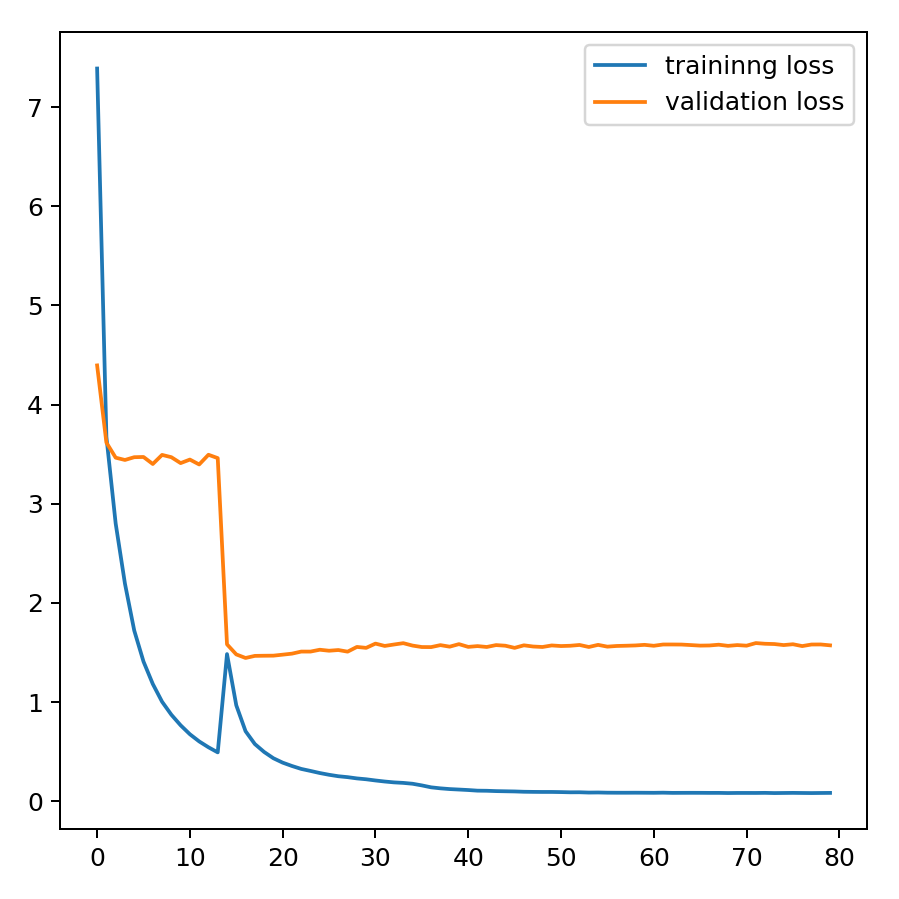

Start/Continue training from epoch 80
Finish training for 80 epochs


In [8]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 5))
exp1.run(num_epochs=80, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [10]:
class_dict = {'person' :0, 'bird' : 1, 'cat' : 2, 'cow': 3, 'dog': 4, 'horse' : 5, 'sheep' : 6,
                  'aeroplane' :7, 'bicycle' :8, 'boat' :9, 'bus':10, 'car':11, 'motorbike' :12, 'train':13,
                  'bottle' :14, 'chair':15, 'diningtable':16, 'pottedplant':17, 'sofa': 18, 'tvmonitor':19}
class_list = list(class_dict)

color_list = ['b', 'g', 'c', 'm', 'y', 'k', 'w']
conf_threshold = 0.1

# Plot single image 

In [14]:
s = time.time()
predictions = []
for i in range(len(class_dict)):
    predictions.append([])
print (predictions)
gt_class_count = torch.zeros(len(class_dict)).to(device)
print (gt_class_count)
test_iter = iter(test_loader)
print (len(test_loader))
net.eval()
with torch.no_grad():
#     for img, target, bboxes, labels in test_loader:
    for t in range(1):
        img, target, bboxes, labels= next(test_iter)
        img, target, bboxes, labels= img.to(device).detach()\
        , target.to(device).detach(), bboxes.to(device).detach(), labels.to(device).detach()

        output = net.forward(img)
        output = output[0]
        target = target[0]
        bboxes = bboxes[0]
        labels = labels[0]

        # undo normailization
        img_mod = image_transform(img[0].to('cpu'))

        #gt variables
        gt_bboxes, gt_labels = from_target_to_bndboxes(bboxes, labels)
        
        # output to bndboxes
        output_bboxes, output_labels = from_prediction_to_bndboxes(output, conf_threshold)

        #plot image
        fig, axs = plt.subplots(ncols=1, figsize=(5, 5))
        plot_single_image(output_bboxes, output_labels, gt_bboxes, gt_labels, axs)
        axs.axis('off')
        axs.imshow(img_mod)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
1154


NameError: name 'conf_threshold' is not defined

In [13]:
def image_transform(image, ax=plt):
    normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])    
    image = np.array(normalize(image).numpy())
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    return image


def plot_single_image(output_bboxes, output_class_idx, gt_bboxes, gt_labels, axs) : 
    for i in range(gt_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = gt_bboxes[i,:4]
        print ("GT",i,gt_bboxes[i,:].to('cpu').numpy(), class_list[gt_labels[i]])
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=4,edgecolor='r',facecolor='none')
        axs.add_patch(rect)

    for i in range(output_bboxes.size()[0]):
        xmin, ymin, xmax, ymax = output_bboxes[i,:4]
        t = output_class_idx[i]
        print (output_bboxes[i,:].to('cpu').numpy(), class_list[t])
        color = color_list[t % len(color_list)]
        rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=2,edgecolor=color,facecolor='none')
        axs.add_patch(rect)

    
def from_target_to_bndboxes(bboxes, labels):

    mask = bboxes[:,3]>0.0
    
    gt_bboxes = bboxes[mask]*448.0
    gt_labels = labels[mask]

    return gt_bboxes, gt_labels.view(-1,1).byte()

    
    
def from_prediction_to_bndboxes(output, conf_threshold):
    
    output_bboxes =  output.view(-1, 30)[:,:10]
    maxi = torch.eq(output_bboxes[:,[4,9]], torch.max(output_bboxes[:,[4,9]], dim =1)[0].unsqueeze(1)).view(-1)
    output_bboxes = output_bboxes.contiguous().view(-1,5)[maxi]
    output_class_prob, output_labels = torch.max(output.view(-1, 30)[:,10:], dim = 1)
    output_bboxes[:,4] *= output_class_prob

    # calculate bndboxes to xmin, ymin, xmax, ymax
    cell_size = 1./7.0
    C = 7
    wh= torch.pow(output_bboxes[:,[2,3]], 2)
    ij = torch.from_numpy(np.array([ (i%C, i//C) for i in range(C*C)])).to(device).float()
    xy_center = (output_bboxes[:,[0,1]] + ij)* cell_size
    xy_min = xy_center - wh/2
    xy_min = torch.max(xy_min, torch.zeros_like(xy_min)) * 448.0
    xy_max = xy_center + wh/2
    xy_max = torch.min(xy_max, torch.ones_like(xy_min)) * 448.0
    output_bboxes[:,:4] = torch.cat((xy_min,  xy_max), dim = 1)

    # Choose high confidence bnd boxes
    conf_selected =output_bboxes[:,4] > conf_threshold
    output_bboxes = output_bboxes[conf_selected]
    output_labels = output_labels[conf_selected]
    
    return output_bboxes, output_labels.view(-1,1).byte()